# IMPORTS AND CONFIGURATION

In [29]:
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DATA LOADING

In [31]:
path_to_dataset = '../../dataset/swat/SWaT_Dataset_Attack_v0.xlsx'
sheet_name = 'Combined Data'

In [32]:
dfOrig = pd.read_excel(path_to_dataset, 
                       sheet_name = sheet_name, 
                       header = 1)

/home/manuelfrancop/Escritorio/TS-SHAP/ts_shap_entorno/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# DATA PREPROCESSING

In [33]:
df = dfOrig.copy()
df['Normal/Attack'] = df['Normal/Attack'].apply(lambda x: 0 if x == 'Normal' else 1).astype('category')
df['Index'] = df.index
labels = df['Normal/Attack']
data = df.drop(columns=[' Timestamp', 'Normal/Attack'])

In [34]:
segment_size = 500
padding_size = 50
train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

In [35]:
train_data_list, val_data_list, test_data_list, padding_data_list = [], [], [], []
train_labels_list, val_labels_list, test_labels_list, padding_labels_list = [], [], [], []
train_indexes_list, val_indexes_list, test_indexes_list, padding_indexes_list = [], [], [], []

for i in range(0, len(df), segment_size):

    init = i
    end = min(i + segment_size, len(df))

    segment_indexes = df['Index'].iloc[init:end]
    
    segment_data = data.iloc[init:end]
    segment_labels = labels.iloc[init:end]
    
    train_split_index = int(train_percentage * len(segment_data))
    val_split_index = int((train_percentage + val_percentage) * len(segment_data))
    
    #TRAIN
    train_data_list.append(segment_data.iloc[:train_split_index])
    train_labels_list.append(segment_labels.iloc[:train_split_index])
    
    # Padding before VALIDATION
    padding_start = max(0, train_split_index - padding_size)
    padding_data_list.append(segment_data.iloc[padding_start:train_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start:train_split_index])
    
    # VALIDATION
    val_data_list.append(segment_data.iloc[train_split_index:val_split_index])
    val_labels_list.append(segment_labels.iloc[train_split_index:val_split_index])
    
    # Padding before TEST
    padding_start_val = max(0, val_split_index - padding_size)
    padding_end_val = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[padding_start_val:val_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start_val:val_split_index])
    
    # TEST
    test_data_list.append(segment_data.iloc[val_split_index:])
    test_labels_list.append(segment_labels.iloc[val_split_index:])
    
    # Padding before next SEGMENT
    padding_end = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[val_split_index:padding_end])
    padding_labels_list.append(segment_labels.iloc[val_split_index:padding_end])

    train_indexes_list.append(segment_indexes.iloc[:train_split_index])
    val_indexes_list.append(segment_indexes.iloc[train_split_index:val_split_index])
    test_indexes_list.append(segment_indexes.iloc[val_split_index:])


# Concatenate
train_data = pd.concat(train_data_list).reset_index(drop=True)
val_data = pd.concat(val_data_list).reset_index(drop=True)
test_data = pd.concat(test_data_list).reset_index(drop=True)
padding_data = pd.concat(padding_data_list).reset_index(drop=True)

train_labels = pd.concat(train_labels_list).reset_index(drop=True)
val_labels = pd.concat(val_labels_list).reset_index(drop=True)
test_labels = pd.concat(test_labels_list).reset_index(drop=True)
padding_labels = pd.concat(padding_labels_list).reset_index(drop=True)

train_indexes = pd.concat(train_indexes_list).reset_index(drop=True)
val_indexes = pd.concat(val_indexes_list).reset_index(drop=True)
test_indexes = pd.concat(test_indexes_list).reset_index(drop=True)


print(f'Train data shape: {train_data.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Train index shape: {train_indexes.shape}')
print()

print(f'Validation data shape: {val_data.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Validation index shape: {val_indexes.shape}')
print()

print(f'Test data shape: {test_data.shape}')
print(f'Test labels shape: {test_labels.shape}')
print(f'Test index shape: {test_indexes.shape}')
print()

x_train = train_data.to_numpy()
y_train = train_labels.to_numpy()
x_val = val_data.to_numpy()
y_val = val_labels.to_numpy()
x_test = test_data.to_numpy()
y_test = test_labels.to_numpy()

Train data shape: (314943, 52)
Train labels shape: (314943,)
Train index shape: (314943,)

Validation data shape: (67488, 52)
Validation labels shape: (67488,)
Validation index shape: (67488,)

Test data shape: (67488, 52)
Test labels shape: (67488,)
Test index shape: (67488,)



In [36]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels, indexes, stride=1, window_size=10):

        self.x = data.to_numpy(dtype=np.float32)  
        self.labels = labels.to_numpy(dtype=np.float32)  
        self.labels = np.array([[1, 0] if label == 0 else [0, 1] for label in self.labels], dtype=np.float32)
        self.indexes = indexes.to_numpy(dtype=np.int32)  
        self.window_size = window_size
        self.stride = stride

        self.valid_idxs = self._preprocess_windows()
        self.n_idxs = len(self.valid_idxs)

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        item = {}
        item["given"] = torch.from_numpy(self.x[i:i + self.window_size]).to(torch.float32)
        item["label"] = torch.tensor(self.labels[i + self.window_size - 1], dtype=torch.float32).to(device)
        item["answer"] = torch.tensor(self.labels[i + self.window_size-1], dtype=torch.float32).to(device)
        item["indexes"] = self.indexes[i + self.window_size - 1]
        return item

    def _preprocess_windows(self):
        temp_valid_idxs = []
        total_windows = len(self.x) - self.window_size + 1
        print(f"Total windows: {total_windows}")
        
        for L in range(0, total_windows, self.stride):
            window_indices = self.indexes[L:L + self.window_size]
            
            if np.all(np.diff(window_indices) == 1):
                temp_valid_idxs.append(L)
        
        print(f"Valid windows: {len(temp_valid_idxs)}")
        return np.array(temp_valid_idxs, dtype=np.int32)

In [37]:
zero_variance_columns = train_data.columns[train_data.nunique() <= 1].tolist()

#remove Index column from train_data
train_data_trans = train_data.drop(columns=['Index'])
val_data_trans = val_data.drop(columns=['Index'])
test_data_trans = test_data.drop(columns=['Index'])

train_data_trans = train_data_trans.drop(columns=zero_variance_columns)
val_data_trans = val_data_trans.drop(columns=zero_variance_columns)
test_data_trans = test_data_trans.drop(columns=zero_variance_columns)

categorical_columns = [col for col in train_data_trans.columns if train_data_trans[col].nunique() < 10]
continuous_columns = [col for col in train_data_trans.columns if col not in categorical_columns]

print(f"Zero variance columns: {len(zero_variance_columns)}: {zero_variance_columns}")
print(f'Categorical columns: {len(categorical_columns)}: {categorical_columns}')
print(f'Continuous columns: {len(continuous_columns)}: {continuous_columns}')

Zero variance columns: 7: [' P202', 'P301', 'P401', 'P404', 'P502', 'P601', 'P603']
Categorical columns: 19: [' MV101', 'P101', 'P102', ' MV201', ' P201', 'P203', ' P204', 'P205', 'P206', 'MV301', 'MV302', ' MV303', 'MV304', 'P302', 'P402', 'P403', 'UV401', 'P501', 'P602']
Continuous columns: 25: ['FIT101', 'LIT101', ' AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']


In [38]:
for col in categorical_columns:
    train_data_trans[col] = train_data_trans[col].astype('category')
    val_data_trans[col] = val_data_trans[col].astype('category')
    test_data_trans[col] = test_data_trans[col].astype('category')

In [39]:
#Standardize continuous columns and one-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

pipeline.fit(train_data_trans)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['FIT101', 'LIT101',
                                                   ' AIT201', 'AIT202',
                                                   'AIT203', 'FIT201',
                                                   'DPIT301', 'FIT301',
                                                   'LIT301', 'AIT401', 'AIT402',
                                                   'FIT401', 'LIT401', 'AIT501',
                                                   'AIT502', 'AIT503', 'AIT504',
                                                   'FIT501', 'FIT502', 'FIT503',
                                                   'FIT504', 'PIT501', 'PIT502',
                                                   'PIT503', 'FIT601']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [' MV101', 'P101', 'P102',
                                                   ' MV201', ' P201', 'P203',
                                                   ' P204', 'P205', 'P206',
                                                   'MV301', 'MV302', ' MV303',
                                                   'MV304', 'P302', 'P402',
                                                   'P403', 'UV401', 'P501',
                                                   'P602'])]))])

In [40]:
x_train_trans = pipeline.transform(train_data_trans)
x_val_trans = pipeline.transform(val_data_trans)
x_test_trans = pipeline.transform(test_data_trans)

In [41]:
categorical_feature_names = pipeline.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(categorical_columns)
all_feature_names = continuous_columns + list(categorical_feature_names)

x_train_df = pd.DataFrame(x_train_trans, columns=all_feature_names)
x_val_df = pd.DataFrame(x_val_trans, columns=all_feature_names)
x_test_df = pd.DataFrame(x_test_trans, columns=all_feature_names)

x_train_df.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,P402_1,P402_2,P403_1,P403_2,UV401_1,UV401_2,P501_1,P501_2,P602_1,P602_2
0,0.599851,-0.672078,1.470969,-1.170701,0.500734,0.657637,0.507553,0.543890,0.571288,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.615963,-0.671764,1.470969,-1.170701,0.500734,0.657637,0.507553,0.545442,0.571288,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.651945,-0.672078,1.470969,-1.187723,0.500734,0.654918,0.500114,0.545865,0.575259,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.689807,-0.671138,1.470969,-1.187723,0.500734,0.654918,0.500114,0.545865,0.579231,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.719076,-0.667064,1.470969,-1.187723,0.500734,0.655598,0.500114,0.545865,0.582707,0.549771,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [42]:
print(f"Train data transformed shape: {x_train_df.shape}")
print(f"Validation data transformed shape: {x_val_df.shape}")
print(f"Test data transformed shape: {x_test_df.shape}")

variable_names = all_feature_names
print("Variables names after transformation:")
print(variable_names)

Train data transformed shape: (314943, 69)
Validation data transformed shape: (67488, 69)
Test data transformed shape: (67488, 69)
Variables names after transformation:
['FIT101', 'LIT101', ' AIT201', 'AIT202', 'AIT203', 'FIT201', 'DPIT301', 'FIT301', 'LIT301', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601', ' MV101_0', ' MV101_1', ' MV101_2', 'P101_1', 'P101_2', 'P102_1', 'P102_2', ' MV201_0', ' MV201_1', ' MV201_2', ' P201_1', ' P201_2', 'P203_1', 'P203_2', ' P204_1', ' P204_2', 'P205_1', 'P205_2', 'P206_1', 'P206_2', 'MV301_0', 'MV301_1', 'MV301_2', 'MV302_0', 'MV302_1', 'MV302_2', ' MV303_0', ' MV303_1', ' MV303_2', 'MV304_0', 'MV304_1', 'MV304_2', 'P302_1', 'P302_2', 'P402_1', 'P402_2', 'P403_1', 'P403_2', 'UV401_1', 'UV401_2', 'P501_1', 'P501_2', 'P602_1', 'P602_2']


In [43]:
trainDataset = TimeSeriesDataset(data=pd.DataFrame(x_train_df) , labels=train_labels, indexes=train_indexes , stride=1, window_size=10)
valDataset = TimeSeriesDataset(data=pd.DataFrame(x_val_df) , labels=val_labels, indexes=val_indexes , stride=1, window_size=10)
testDataset = TimeSeriesDataset(data=pd.DataFrame(x_test_df) , labels=test_labels, indexes=test_indexes , stride=1, window_size=10)

Total windows: 314934
Valid windows: 306843
Total windows: 67479
Valid windows: 59388
Total windows: 67479
Valid windows: 59388


In [44]:
#For each original variable, store the indices of the generated variables in all_feature_names

variables_map = {}

#Continuous variables
for v in continuous_columns:
    variables_map[v] = [all_feature_names.index(v)]  

#Categorical variables
encoder = pipeline.named_steps["preprocessor"].transformers_[1][1] 
for v, categories in zip(categorical_columns, encoder.categories_):
    encoded_names = [f"{v}_{category}" for category in categories]
    indexes = [all_feature_names.index(name) for name in encoded_names]
    variables_map[v] = indexes

In [45]:
swat_process = [
    # P1
    [0, 1, 2, 3, 4],  # FIT101, LIT101, MV101, P101, P102
    
    # P2
    [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],  # AIT201, AIT202, AIT203, FIT201, MV201, P201, P203, P204, P205, P206
    
    # P3
    [15, 16, 17, 18, 19, 20, 21, 22],  # DPIT301, FIT301, LIT301, MV301, MV302, MV303, MV304, P302
    
    # P4 
    [23, 24, 25, 26, 27, 28, 29],  # AIT401, AIT402, FIT401, LIT401, P402, P403, UV401
    
    # P5
    [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],  # AIT501, AIT502, AIT503, AIT504, FIT501, FIT502, FIT503, FIT504, P501, PIT501, PIT502, PIT503
    
    # P6
    [42,43]  # FIT601, p602
]

# TRAINING MODEL

In [46]:
class StackedLSTM(torch.nn.Module):

    def __init__(self, n_tags, n_classes, hidden_size=64, num_layers=3, bidirectional=True, dropout=0):
        super().__init__()
        self.rnn = torch.nn.LSTM(
            input_size=n_tags,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
        )
        self.fc = torch.nn.Linear(2*hidden_size if bidirectional else hidden_size, n_classes)

    def forward(self, x):
        x = x.transpose(0, 1)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return out

In [47]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)  
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Optimal hyperparameters
input_dim = trainDataset[0]['given'].shape[1]
hidden_dim = 32
num_layers = 2
dropout = 0.2
num_classes = 2
learning_rate = 0.001
num_epochs = 5
batch_size = 2048
alpha = 1
gamma = 2


model = StackedLSTM(n_tags=input_dim, n_classes=num_classes, hidden_size=hidden_dim, num_layers=num_layers).to(device)
criterion = FocalLoss(alpha=alpha, gamma=gamma)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

trainBool = False
if trainBool:

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data_batch in train_loader:
            x_batch = data_batch["given"].to(device)
            y_batch = data_batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            y_batch_indices = torch.argmax(y_batch, dim=1)            
            loss = criterion(outputs, y_batch_indices)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}')

        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data_batch in val_loader:
                x_batch = data_batch["given"].to(device)
                y_batch = data_batch["label"].to(device)
                outputs = model(x_batch)
                y_batch_indices = torch.argmax(y_batch, dim=1)
                predicted = torch.argmax(outputs, dim=1)
                loss = criterion(outputs, y_batch_indices)
                val_loss += loss.item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch_indices.cpu().numpy())

        val_loss /= len(val_loader)

        all_preds = np.array(all_preds).reshape(-1)
        all_labels = np.array(all_labels).reshape(-1)

        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f'Validation Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}\n')

    torch.save(model.state_dict(), 'ADmodel.pt')

else:
    model.load_state_dict(torch.load('ADmodel.pt'))

/tmp/ipykernel_1067929/2575277059.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('ADmodel.pt'))


# MODEL TESTING

Test Accuracy: 0.9782 | Precision: 0.9718 | Recall: 0.9259 | F1-score: 0.9473



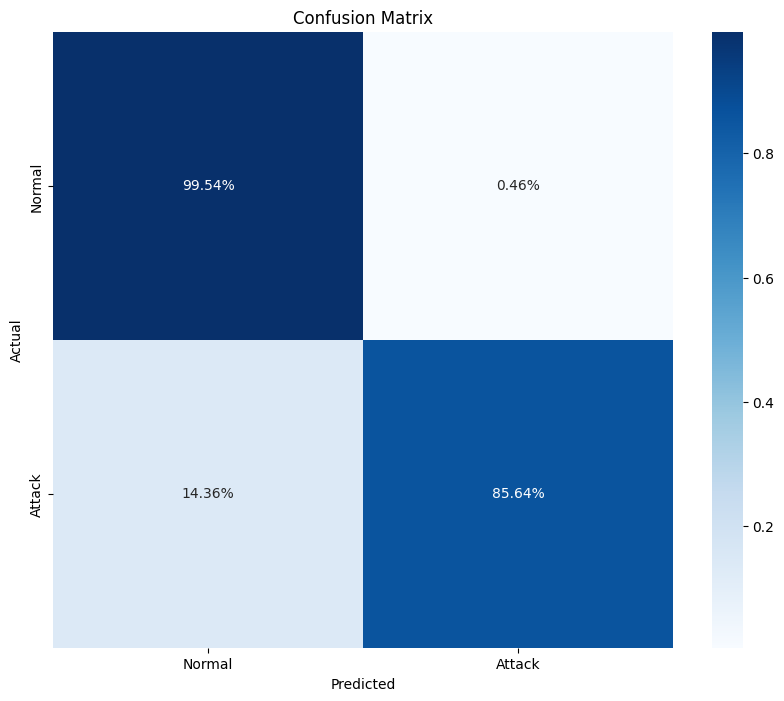

In [48]:
model.eval()
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for data_batch in test_loader:
        x_batch = data_batch["given"].to(device)
        y_batch = data_batch["label"].to(device)
        outputs = model(x_batch)
        y_batch_indices = torch.argmax(y_batch, dim=1)
        predicted = torch.argmax(outputs, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch_indices.cpu().numpy())

all_preds = np.array(all_preds).reshape(-1)
all_labels = np.array(all_labels).reshape(-1)

accuracy = (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f'Test Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}\n')

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# TSG SHAP BASIC CONFIGURATION

In [49]:
import tsg_shap
from tsg_shap import StrategySubsets, StrategyGrouping, StrategyPrediction

In [50]:
random_samples = random.sample(range(len(trainDataset)), 100)
support = [trainDataset[idx] for idx in random_samples]

begin = 190 #begining instant to be explained
end = begin + 100 #end instant to be explained
test = [testDataset[idx] for idx in range(begin, end)]

In [51]:
variables_map_idxs_array = []
for key, value in variables_map.items():
    variables_map_idxs_array.append(value)

# TEMPORAL

/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/tsg_shap.py:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


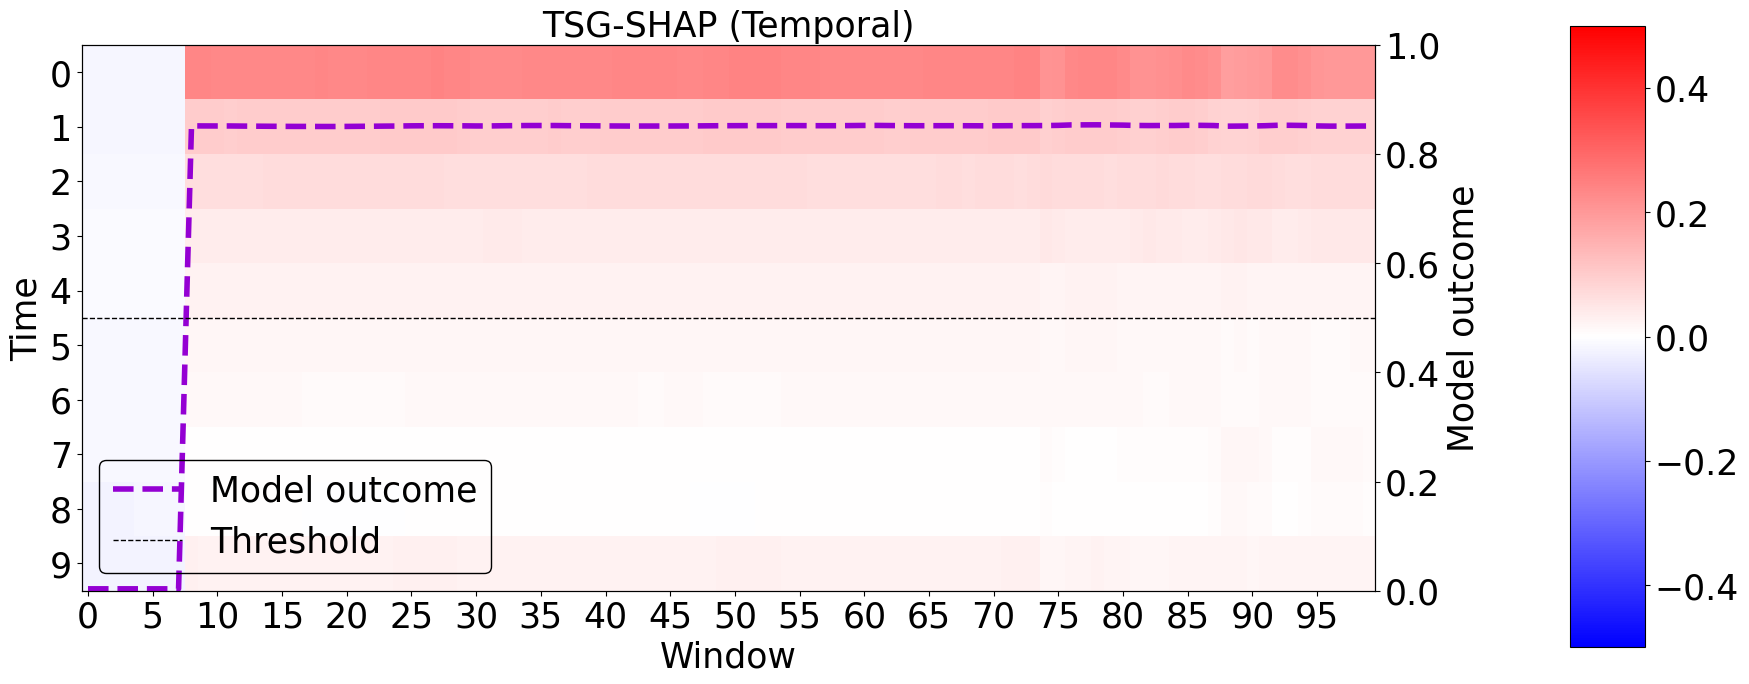

In [52]:
shapley_class = tsg_shap.TSG_SHAP(model, 
                               support ,
                               classToExplain = 1,
                               strategyGrouping=StrategyGrouping.TIME,
                               nameInstants= [str(i) for i in range(10)])

shapley_values = shapley_class.compute_tsgshap(test)

shapley_class.plot_tsgshap(shapley_values, test)

# FEATURE

/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/tsg_shap.py:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


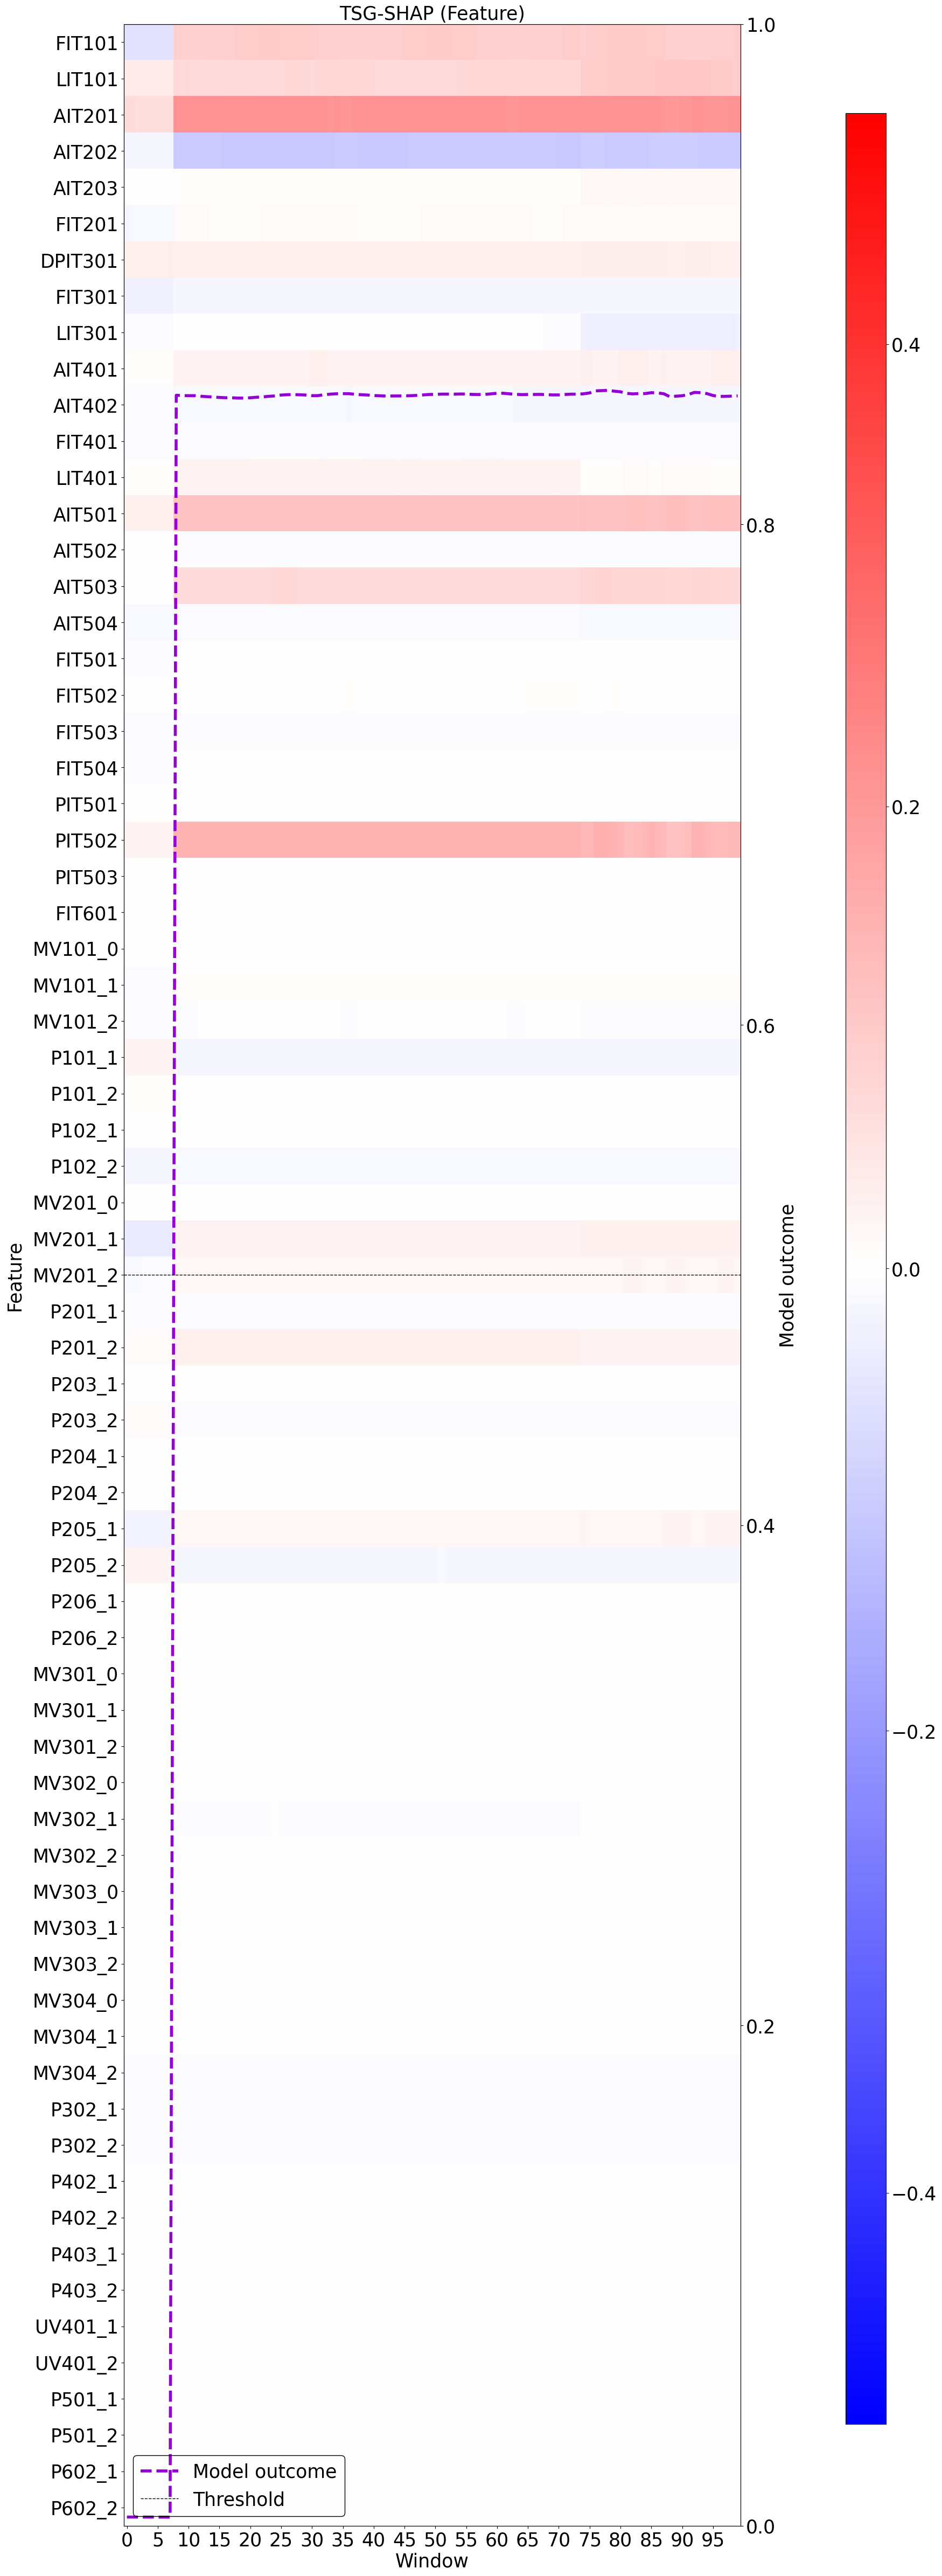

In [53]:
shapley_class = tsg_shap.TSG_SHAP(model, 
                               support ,
                               classToExplain = 1,
                               strategyGrouping=StrategyGrouping.FEATURE,
                               nameFeatures=variable_names)

shapley_values = shapley_class.compute_tsgshap(test)

shapley_class.plot_tsgshap(shapley_values, test)

# MULTIFEATURE

In [54]:
shapley_class = tsg_shap.TSG_SHAP(model, 
                               support ,
                               classToExplain = 1,
                               strategyGrouping=StrategyGrouping.MULTIFEATURE,
                               customGroups=variables_map_idxs_array,
                               nameGroups = list(variables_map.keys()))

shapley_values = shapley_class.compute_tsgshap(test)

shapley_class.plot_tsgshap(shapley_values, test)

KeyboardInterrupt: 

In [ ]:
import importlib
importlib.reload(tsg_shap)

<module 'tsg_shap' from '/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/__init__.py'>

/home/manuelfrancop/Escritorio/TS-SHAP/gitAbril25/TSG-SHAP/tsg_shap/tsg_shap.py:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


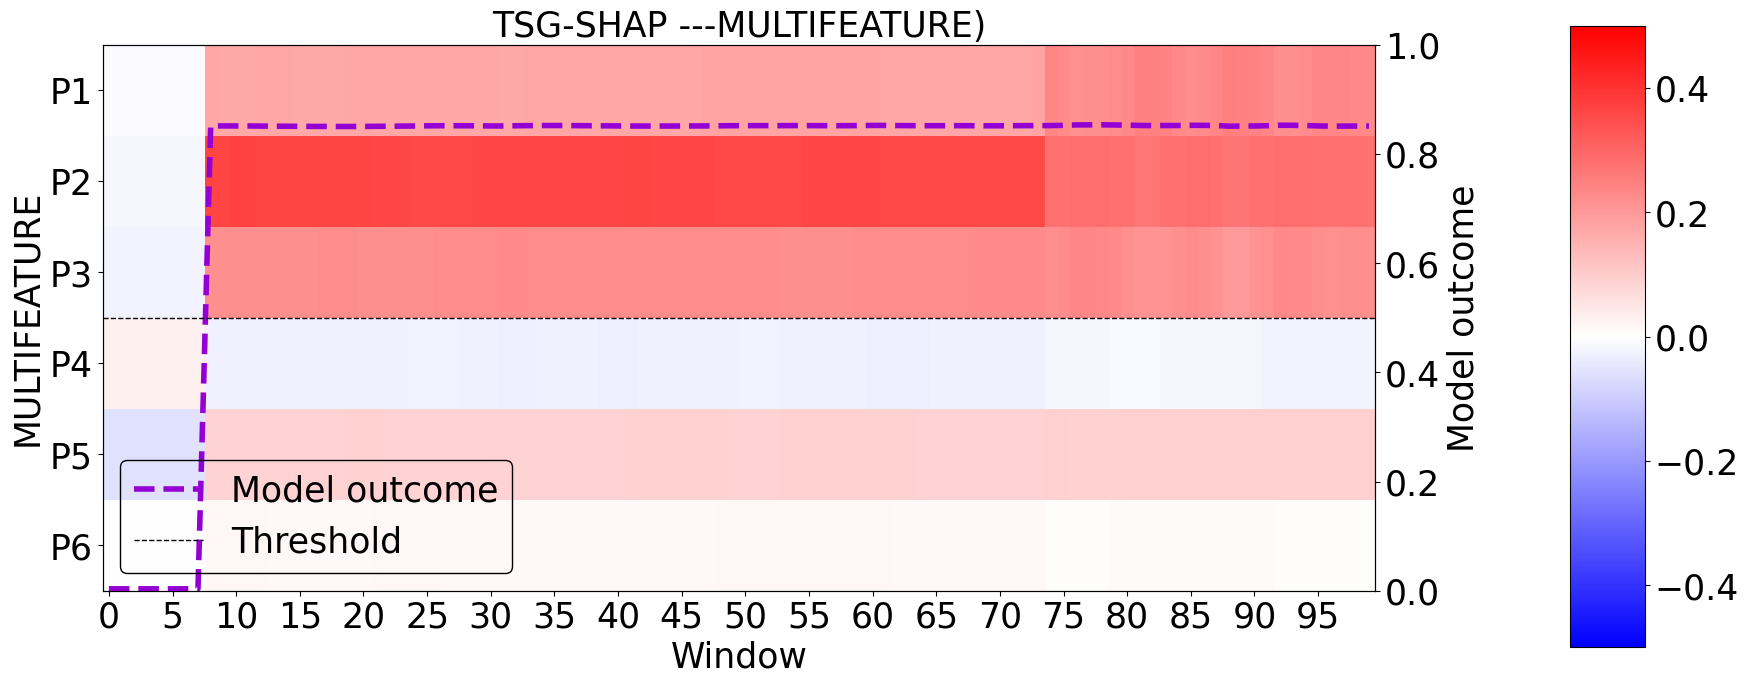

In [ ]:
shapley_class = tsg_shap.TSG_SHAP(model, 
                               support ,
                               classToExplain = 1,
                               strategyGrouping=StrategyGrouping.MULTIFEATURE,
                               customGroups=swat_process,
                               nameGroups = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6'])

shapley_values = shapley_class.compute_tsgshap(test)

shapley_class.plot_tsgshap(shapley_values, test)